<a href="https://colab.research.google.com/github/victor-roris/mediumseries/blob/master/NLP/NLPModel_MultiLabel_NaiveBayes_Count%26TFIDFVectorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Model with Naive Bayes Classifier 

In this notebook, we are going to use a Naive Bayes Classifier for Multinomial Model to predict categories of text. To vectorize the text we are going to use the combination of CountVector (multi-hot array) and TFIDF approach.

Naive Bayes: https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes

Sklearn CountVectorizer: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

Sklearn TFIDF: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

Notebook adapted from: https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568



In [0]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

## Data

### Fetch data

We are using a relatively large data set of Stack Overflow questions and tags.

In [2]:
df = pd.read_csv('https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv')
df = df[pd.notnull(df['tags'])]
categories = df["tags"].unique()

print(f'Number of examples : {len(df)}')
print(f'Number of words in the data: {df["post"].apply(lambda x: len(x.split(" "))).sum()}')
print(f'Number of categorie : {len(categories)}')
print()
print(df.head(10))
print()
print(f'Categories: {categories}')


Number of examples : 40000
Number of words in the data: 10286120
Number of categorie : 20

                                                post           tags
0  what is causing this behavior  in our c# datet...             c#
1  have dynamic html load as if it was in an ifra...        asp.net
2  how to convert a float value in to min:sec  i ...    objective-c
3  .net framework 4 redistributable  just wonderi...           .net
4  trying to calculate and print the mean and its...         python
5  how to give alias name for my website  i have ...        asp.net
6  window.open() returns null in angularjs  it wo...      angularjs
7  identifying server timeout quickly in iphone  ...         iphone
8  unknown method key  error in rails 2.3.8 unit ...  ruby-on-rails
9  from the include  how to show and hide the con...      angularjs

Categories: ['c#' 'asp.net' 'objective-c' '.net' 'python' 'angularjs' 'iphone'
 'ruby-on-rails' 'ios' 'c' 'sql' 'java' 'jquery' 'css' 'c++' 'php'
 'android' 'my

Visualize data

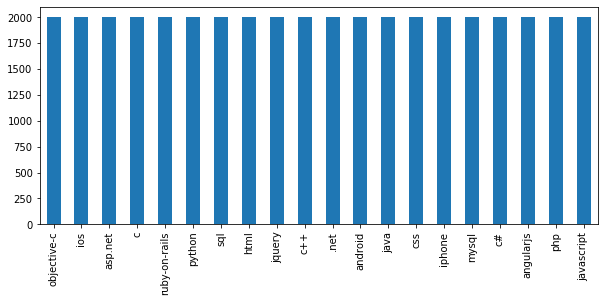

In [3]:
plt.figure(figsize=(10,4))
df.tags.value_counts().plot(kind='bar');

The classes are very well balanced.

### Text pre-processing

Our text cleaning step includes HTML decoding, remove stop words, change text to lower case, remove punctuation, remove bad characters, and so on.

In [7]:
 nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    

print(f'Example text previous cleaning : {df["post"].values[10]}')

df['post'] = df['post'].apply(clean_text)

print(f'Example text previous cleaning : {df["post"].values[10]}')

Example text previous cleaning : when we need interface c# <blockquote>    <strong>possible duplicate:</strong><br>   <a href= https://stackoverflow.com/questions/240152/why-would-i-want-to-use-interfaces >why would i want to use interfaces </a>   <a href= https://stackoverflow.com/questions/9451868/why-i-need-interface >why i need interface </a>    </blockquote>     i want to know where and when to use it     for example    <pre><code>interface idemo {  // function prototype  public void show(); }  // first class using the interface class myclass1 : idemo {  public void show()  {   // function body comes here   response.write( i m in myclass );  }  }  // second class using the interface class myclass2 : idemo {  public void show()   {   // function body comes here   response.write( i m in myclass2 );   response.write( so  what  );  } </code></pre>   these two classes has the same function name with different body. this can be even achieved without interface. then why we need an interf

In [9]:
print(f'Number of words in the cleaning data: {df["post"].apply(lambda x: len(x.split(" "))).sum()}')

Number of words in the cleaning data: 3424297


### Prepare data

In [0]:
X = df.post
y = df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

## Model training

To train the model we will convert our text documents to a matrix of token counts (CountVectorizer), then transform the count matrix to a normalized tf-idf representation (tf-idf transformer). 

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

We train the vectorizers and model

In [16]:
%%time
nb.fit(X_train, y_train)

CPU times: user 3.02 s, sys: 67.9 ms, total: 3.08 s
Wall time: 3.09 s


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

## Model evaluation

In [23]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=categories))

accuracy 0.7395
               precision    recall  f1-score   support

           c#       0.63      0.65      0.64       613
      asp.net       0.94      0.86      0.90       620
  objective-c       0.87      0.92      0.90       587
         .net       0.70      0.77      0.73       586
       python       0.73      0.87      0.79       599
    angularjs       0.72      0.51      0.60       589
       iphone       0.77      0.74      0.75       594
ruby-on-rails       0.69      0.89      0.78       610
          ios       0.63      0.59      0.61       617
            c       0.57      0.65      0.60       587
          sql       0.70      0.50      0.59       611
         java       0.79      0.78      0.79       594
       jquery       0.84      0.59      0.69       619
          css       0.66      0.84      0.74       574
          c++       0.64      0.83      0.72       584
          php       0.66      0.64      0.65       578
      android       0.79      0.77      0.78    